# Forecasting casos leves de COVID-19

In [71]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from epiweeks import Week
from itertools import product

# Estatísticas
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Dados

In [2]:
df = pd.read_csv('../data/processed/dados.csv', delimiter = ';')

In [3]:
df.head()

,Unnamed: 0,id,dataInicioSintomas,dataNotificacao,dataAtualizacao,dataEncerramento,dataRegistro,regiao,estadoIBGE,idade
0,1,uVOUpcAwja,2023-11-25,2023-11-27,2023-12-12,2023-12-12,2023-11-27,1,12,25.0
1,2,Cg7XavXuQq,2023-12-01,2023-12-05,2023-12-12,2023-12-11,2023-12-07,1,13,26.0
2,3,bF7E1KySnh,2023-12-09,2023-12-12,2023-12-14,2023-12-14,2023-12-14,1,12,22.0
3,4,A8sEjw9taT,2023-11-21,2023-11-27,2023-12-18,NaN,2023-12-18,1,13,24.0
4,5,CfqY4VBedF,2023-12-11,2023-12-12,2023-12-18,2023-12-18,2023-12-18,1,12,24.0


# Tratamento de dados

In [4]:
df.shape

(2704725, 10)

In [5]:
df1 = df[[
    'dataInicioSintomas',
    'dataNotificacao',
    'dataAtualizacao',
    'dataEncerramento',
    'dataRegistro',
    'regiao',
    'estadoIBGE',
    'idade'
]]

df1.head()

,dataInicioSintomas,dataNotificacao,dataAtualizacao,dataEncerramento,dataRegistro,regiao,estadoIBGE,idade
0,2023-11-25,2023-11-27,2023-12-12,2023-12-12,2023-11-27,1,12,25.0
1,2023-12-01,2023-12-05,2023-12-12,2023-12-11,2023-12-07,1,13,26.0
2,2023-12-09,2023-12-12,2023-12-14,2023-12-14,2023-12-14,1,12,22.0
3,2023-11-21,2023-11-27,2023-12-18,NaN,2023-12-18,1,13,24.0
4,2023-12-11,2023-12-12,2023-12-18,2023-12-18,2023-12-18,1,12,24.0


In [6]:
print(df1.isna().sum())

dataInicioSintomas          0
dataNotificacao             0
dataAtualizacao             0
dataEncerramento      1130459
dataRegistro                0
regiao                      0
estadoIBGE                  0
idade                    2226
dtype: int64


## Criar série temporal por semana epidemiológica

In [7]:
# Converter para datetime
df['dataInicioSintomas'] = pd.to_datetime(df['dataInicioSintomas'])

# Calcular semana epidemiológica e ano epidemiológico
df['semana_epi'] = df['dataInicioSintomas'].apply(lambda x: Week.fromdate(x).week)
df['ano_epi'] = df['dataInicioSintomas'].apply(lambda x: Week.fromdate(x).year)

# Criar coluna dt_event com a data correspondente ao último dia da semana (domingo)
df['dt_event'] = df.apply(lambda row: Week(row['ano_epi'], row['semana_epi']).enddate(), axis=1)

# Criar uma coluna com o número da semana epidemiológica
df['num_semana_epi'] = df['semana_epi']

# Agrupar por dt_event e contar ocorrências
serie_semana = df.groupby(['dt_event', 'num_semana_epi']).size().reset_index(name='count')

# Mostrar a série temporal semanal com a coluna de semana epidemiológica
print(serie_semana)

       dt_event  num_semana_epi   count
0    2023-01-07               1  103376
1    2023-01-14               2   64015
2    2023-01-21               3   45188
3    2023-01-28               4   37199
4    2023-02-04               5   35865
..          ...             ...     ...
99   2024-11-30              48   13603
100  2024-12-07              49   16290
101  2024-12-14              50   14014
102  2024-12-21              51    6288
103  2024-12-28              52       3

[104 rows x 3 columns]


In [8]:
serie_semana.dtypes

dt_event          object
num_semana_epi     int64
count              int64
dtype: object

In [9]:
# Excluir observação final por estar com um número muito reduzido de casos
serie_semana_analise = serie_semana.drop(index=103)

print(serie_semana_analise)

       dt_event  num_semana_epi   count
0    2023-01-07               1  103376
1    2023-01-14               2   64015
2    2023-01-21               3   45188
3    2023-01-28               4   37199
4    2023-02-04               5   35865
..          ...             ...     ...
98   2024-11-23              47   10259
99   2024-11-30              48   13603
100  2024-12-07              49   16290
101  2024-12-14              50   14014
102  2024-12-21              51    6288

[103 rows x 3 columns]


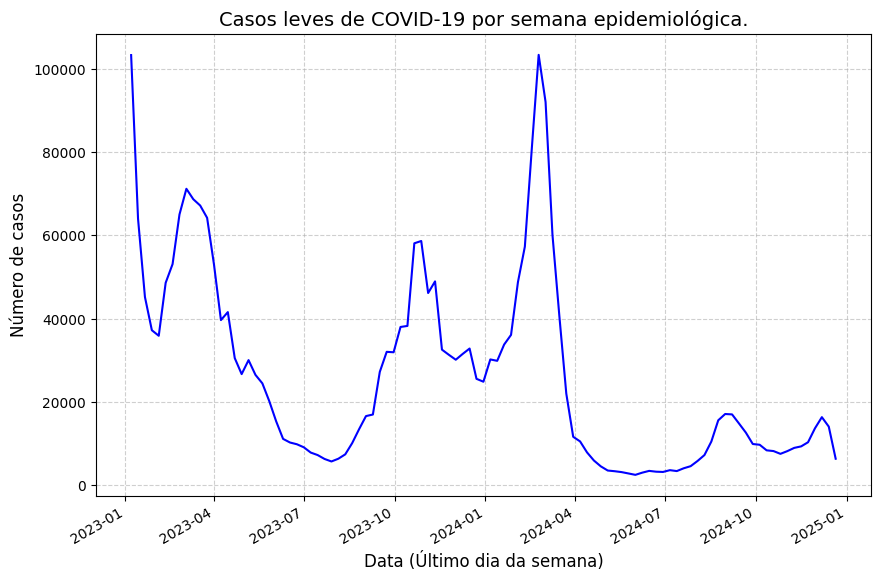

In [10]:
# Visualização dos dados
plt.figure(figsize=(10, 6))
plt.plot(serie_semana_analise['dt_event'], serie_semana_analise['count'], color='b')

plt.title('Casos leves de COVID-19 por semana epidemiológica.', fontsize=14)
plt.xticks(rotation=30, ha='right')
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.xlabel('Data (Último dia da semana)', fontsize=12)
plt.ylabel('Número de casos', fontsize=12)

plt.show()

# Análise exploratória da ST

### Estacionariedade
Após diferenciação de primeira ordem os dados apresentaram comportamento estacionário.

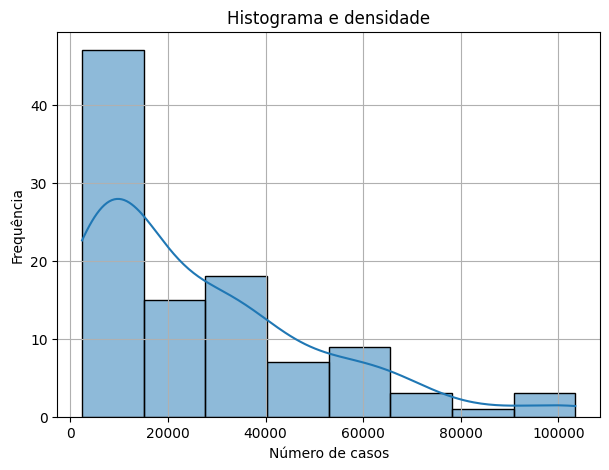

In [11]:
# Histograma
plt.figure(figsize=(7, 5))
sns.histplot(serie_semana_analise['count'], kde=True)
plt.xlabel('Número de casos')
plt.ylabel('Frequência')
plt.title('Histograma e densidade')
plt.grid(True)
plt.show()

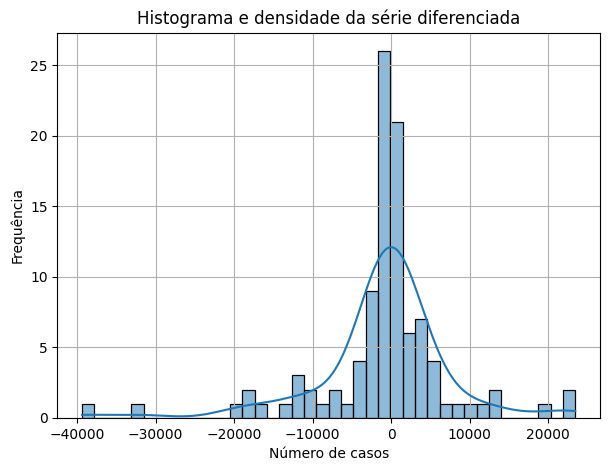

In [12]:
# Histograma diferenciado
plt.figure(figsize=(7, 5))
sns.histplot(serie_semana_analise['count'].diff(), kde=True)
plt.xlabel('Número de casos')
plt.ylabel('Frequência')
plt.title('Histograma e densidade da série diferenciada')
plt.grid(True)
plt.show()

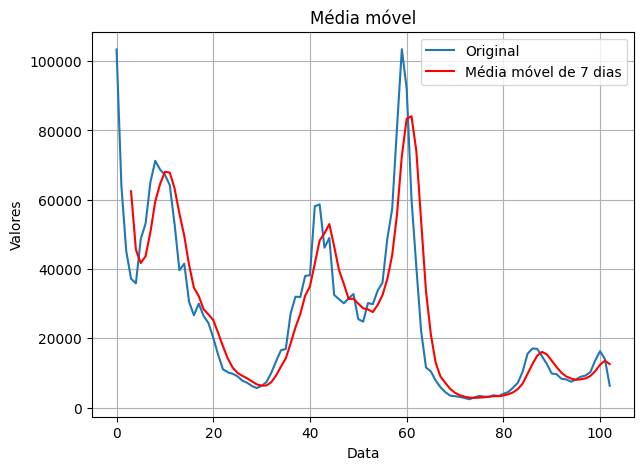

In [13]:
# Média móvel
plt.figure(figsize=(7,5))
values = serie_semana_analise['count']

rolling_mean = values.rolling(window=4).mean()
plt.plot(values, label='Original')
plt.plot(rolling_mean, label='Média móvel de 7 dias', color='red')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.title('Média móvel')
plt.legend()
plt.grid(True)
plt.show()

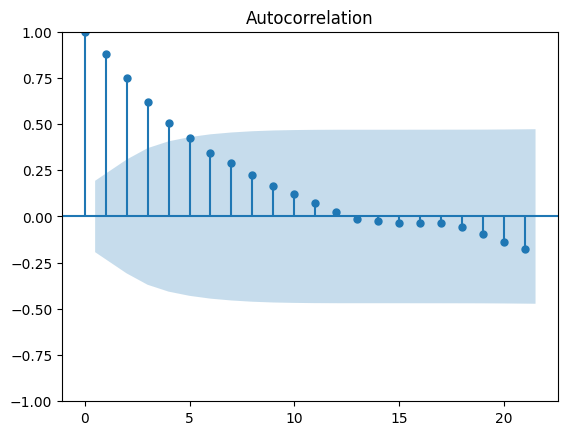

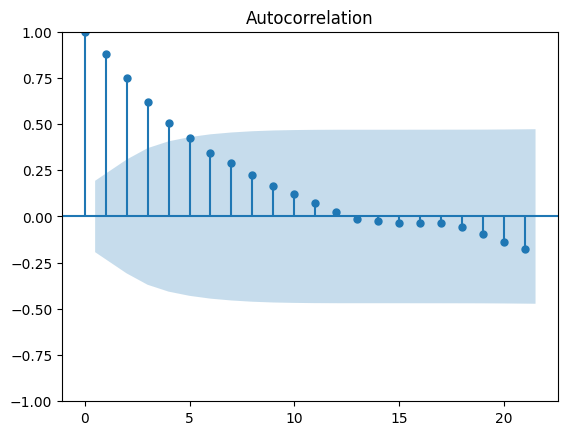

In [15]:
# Autocorrelação
%matplotlib inline
plot_acf(serie_semana_analise['count'])

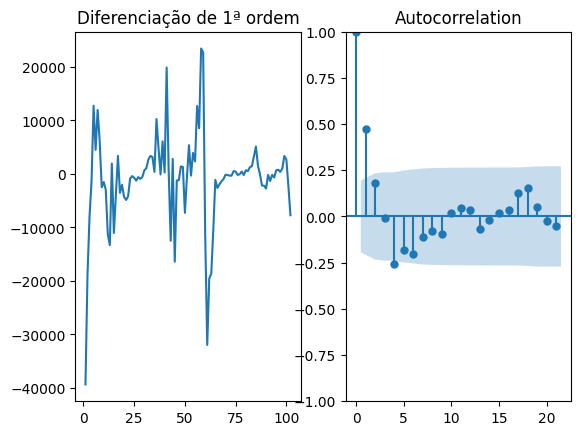

In [16]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('Diferenciação de 1ª ordem')
ax1.plot(serie_semana_analise['count'].diff())

ax2 = f.add_subplot(122)
plot_acf(serie_semana_analise['count'].diff().dropna(), ax=ax2)
plt.show()

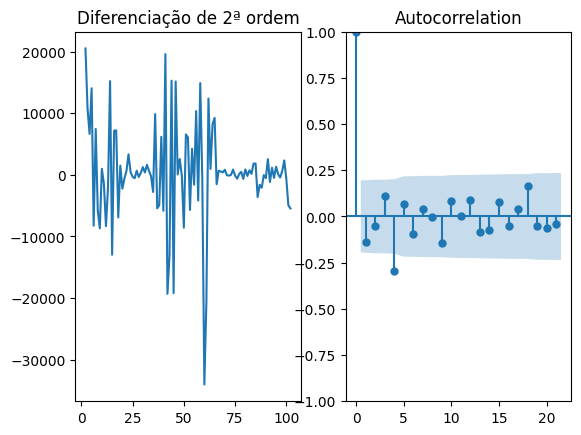

In [17]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('Diferenciação de 2ª ordem')
ax1.plot(serie_semana_analise['count'].diff().diff())

ax2 = f.add_subplot(122)
plot_acf(serie_semana_analise['count'].diff().diff().dropna(), ax=ax2)
plt.show()

In [18]:
# Teste Dickey-Fuller para raiz unitária
result = adfuller(serie_semana_analise['count'].dropna())
print('p-valor: ', result[1])

result = adfuller(serie_semana_analise['count'].diff().dropna())
print('p-valor: ', result[1])

result = adfuller(serie_semana_analise['count'].diff().diff().dropna())
print('p-valor: ', result[1])

p-valor:  0.06721162494254816
p-valor:  4.4935815858051956e-08
p-valor:  1.8711584270320488e-06


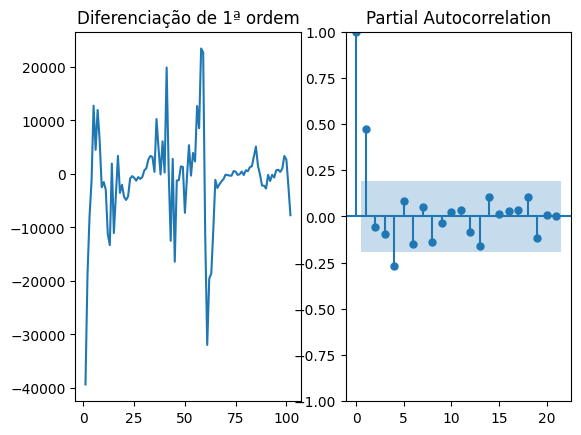

In [19]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('Diferenciação de 1ª ordem')
ax1.plot(serie_semana_analise['count'].diff())

ax2 = f.add_subplot(122)
plot_pacf(serie_semana_analise['count'].diff().dropna(), ax=ax2)
plt.show()

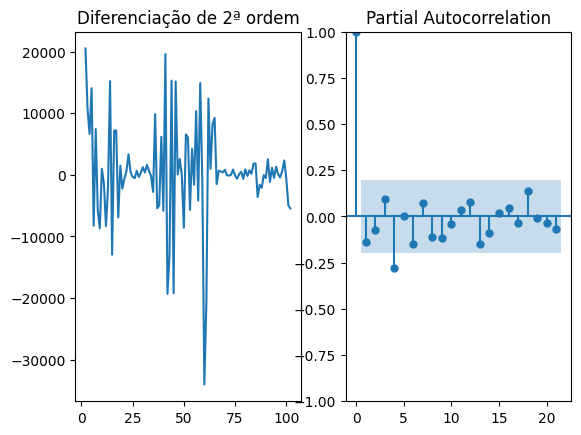

In [20]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('Diferenciação de 2ª ordem')
ax1.plot(serie_semana_analise['count'].diff().diff())

ax2 = f.add_subplot(122)
plot_pacf(serie_semana_analise['count'].diff().diff().dropna(), ax=ax2)
plt.show()

In [17]:
# Converter a coluna de datas para o formato datetime e definir como índice
serie_semana_analise['dt_event'] = pd.to_datetime(serie_semana_analise['dt_event'])
serie_semana_analise.set_index('dt_event', inplace=True)

In [18]:
# Criar e ajustar o modelo ARIMA
arima_model = ARIMA(serie_semana_analise['count'], order=(2, 1, 1))  # Configurar o modelo ARIMA com ordem (p,d,q)
model = arima_model.fit()

# Exibir o resumo do modelo
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                  103
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1064.698
Date:                Fri, 03 Jan 2025   AIC                           2137.396
Time:                        10:25:15   BIC                           2147.896
Sample:                    01-07-2023   HQIC                          2141.647
                         - 12-21-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9247      0.026     34.913      0.000       0.873       0.977
ar.L2         -0.0289      0.025     -1.169      0.242      -0.077       0.020
ma.L1         -1.0000      0.089    -11.275      0.0

D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible sta

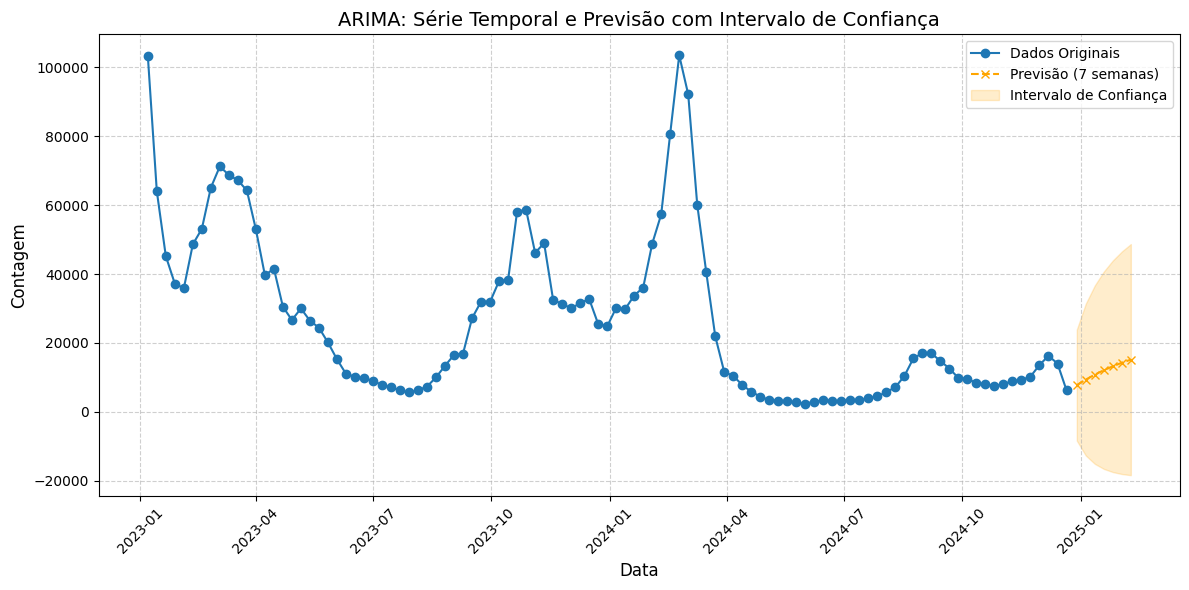

In [19]:
# Fazer previsões com intervalo de confiança
steps_ahead = 7
forecast_object = model.get_forecast(steps=steps_ahead)
forecast_mean = forecast_object.predicted_mean
confidence_intervals = forecast_object.conf_int()

# Preparar as datas para a previsão
forecast_dates = pd.date_range(start=serie_semana_analise.index[-1], periods=steps_ahead + 1, freq='W')[1:]

# Visualizar os resultados
plt.figure(figsize=(12, 6))

# Dados reais
plt.plot(serie_semana_analise.index, serie_semana_analise['count'], label='Dados Originais', marker='o')

# Previsão
plt.plot(forecast_dates, forecast_mean, label=f'Previsão ({steps_ahead} semanas)', color='orange', marker='x', linestyle='--')

# Intervalo de confiança
plt.fill_between(forecast_dates,
                 confidence_intervals.iloc[:, 0],  # Limite inferior
                 confidence_intervals.iloc[:, 1],  # Limite superior
                 color='orange', alpha=0.2, label='Intervalo de Confiança')

# Configurações do gráfico
plt.title('ARIMA: Série Temporal e Previsão com Intervalo de Confiança', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Mostrar o gráfico
plt.show()

# Validação do modelo

In [21]:
# Dividindo séries em treino e teste
train_size = int(len(serie_semana_analise) * 0.8)
treino, teste = serie_semana_analise[0:train_size], serie_semana_analise[train_size:len(serie_semana_analise)]

In [22]:
print(treino)

      dt_event  num_semana_epi   count
0   2023-01-07               1  103376
1   2023-01-14               2   64015
2   2023-01-21               3   45188
3   2023-01-28               4   37199
4   2023-02-04               5   35865
..         ...             ...     ...
77  2024-06-29              26    3111
78  2024-07-06              27    3540
79  2024-07-13              28    3323
80  2024-07-20              29    3995
81  2024-07-27              30    4499

[82 rows x 3 columns]


In [23]:
print(teste)

       dt_event  num_semana_epi  count
82   2024-08-03              31   5749
83   2024-08-10              32   7172
84   2024-08-17              33  10428
85   2024-08-24              34  15537
86   2024-08-31              35  17049
87   2024-09-07              36  16954
88   2024-09-14              37  14776
89   2024-09-21              38  12566
90   2024-09-28              39   9834
91   2024-10-05              40   9652
92   2024-10-12              41   8314
93   2024-10-19              42   8135
94   2024-10-26              43   7466
95   2024-11-02              44   8121
96   2024-11-09              45   8899
97   2024-11-16              46   9262
98   2024-11-23              47  10259
99   2024-11-30              48  13603
100  2024-12-07              49  16290
101  2024-12-14              50  14014
102  2024-12-21              51   6288


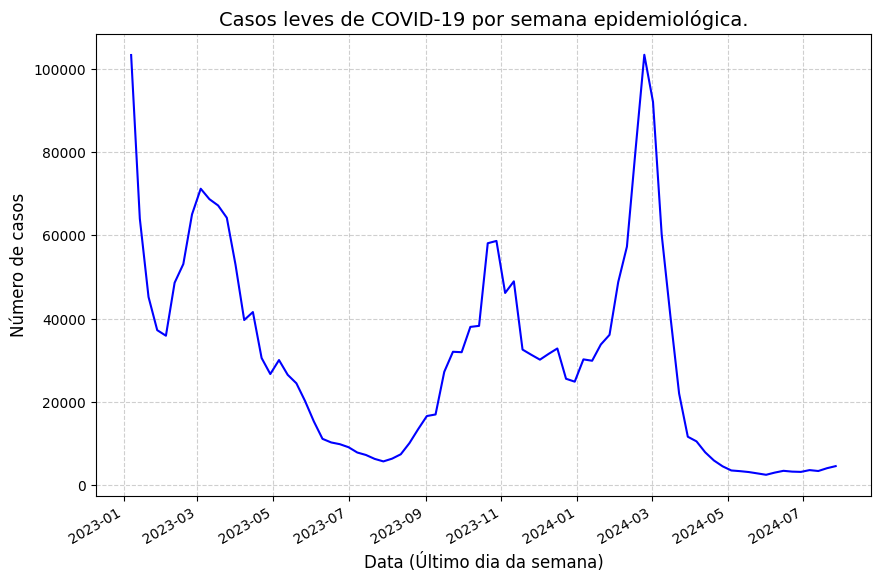

In [24]:
# Visualização dos dados de treino
plt.figure(figsize=(10, 6))
plt.plot(treino['dt_event'], treino['count'], color='b')

plt.title('Casos leves de COVID-19 por semana epidemiológica.', fontsize=14)
plt.xticks(rotation=30, ha='right')
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.xlabel('Data (Último dia da semana)', fontsize=12)
plt.ylabel('Número de casos', fontsize=12)

plt.show()

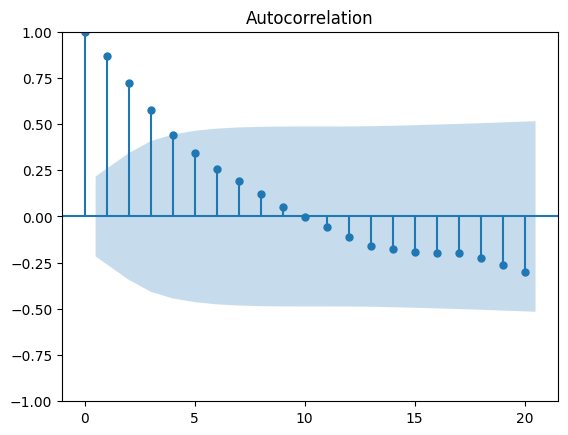

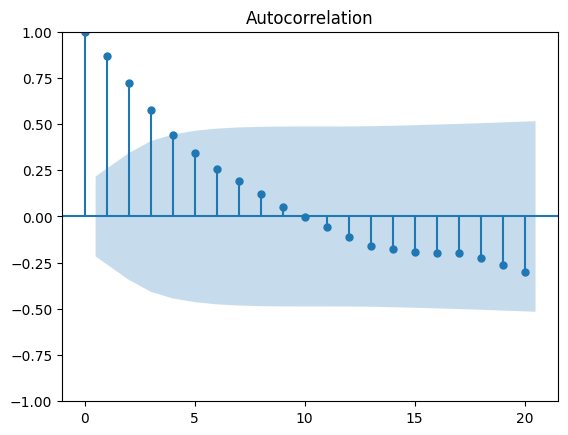

In [25]:
# Autocorrelação
plot_acf(treino['count'])

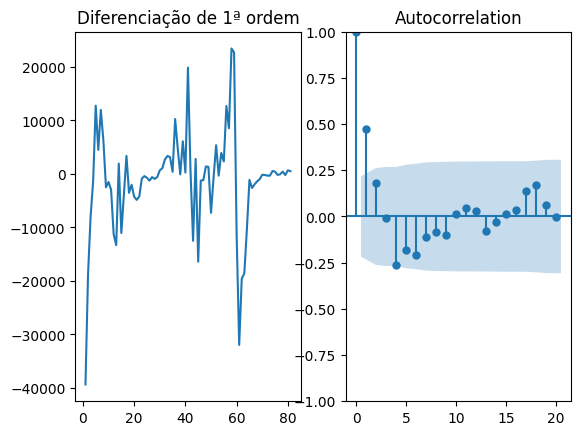

In [26]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('Diferenciação de 1ª ordem')
ax1.plot(treino['count'].diff())

ax2 = f.add_subplot(122)
plot_acf(treino['count'].diff().dropna(), ax=ax2)
plt.show()

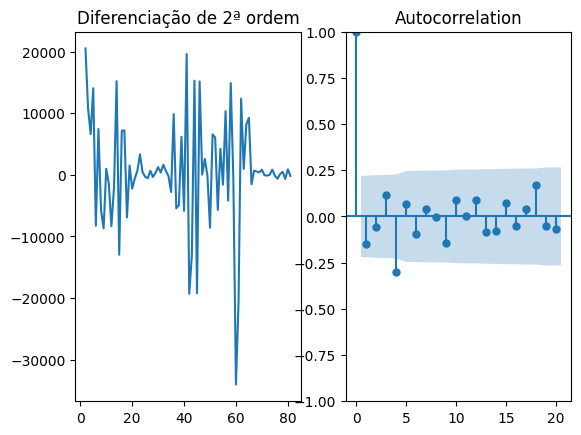

In [27]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('Diferenciação de 2ª ordem')
ax1.plot(treino['count'].diff().diff())

ax2 = f.add_subplot(122)
plot_acf(treino['count'].diff().diff().dropna(), ax=ax2)
plt.show()

In [28]:
# Teste Dickey-Fuller para raiz unitária
result = adfuller(treino['count'].dropna())
print('p-valor: ', result[1])

result = adfuller(treino['count'].diff().dropna())
print('p-valor: ', result[1])

result = adfuller(treino['count'].diff().diff().dropna())
print('p-valor: ', result[1])

p-valor:  0.09918607187502132
p-valor:  7.804126677415089e-08
p-valor:  1.4423675496608647e-09


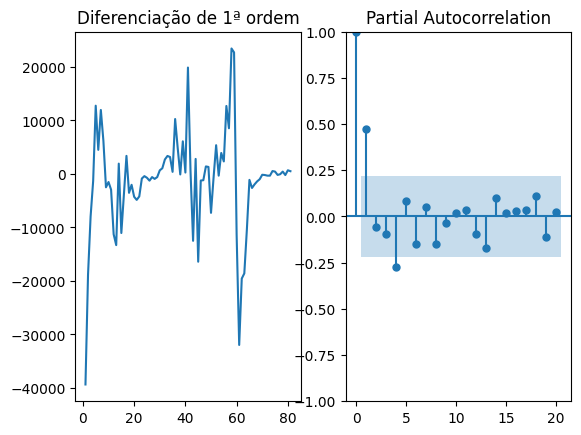

In [29]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('Diferenciação de 1ª ordem')
ax1.plot(treino['count'].diff())

ax2 = f.add_subplot(122)
plot_pacf(treino['count'].diff().dropna(), ax=ax2)
plt.show()

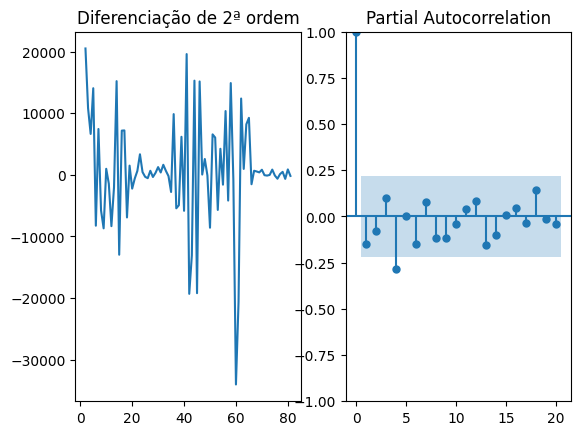

In [30]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('Diferenciação de 2ª ordem')
ax1.plot(treino['count'].diff().diff())

ax2 = f.add_subplot(122)
plot_pacf(treino['count'].diff().diff().dropna(), ax=ax2)
plt.show()

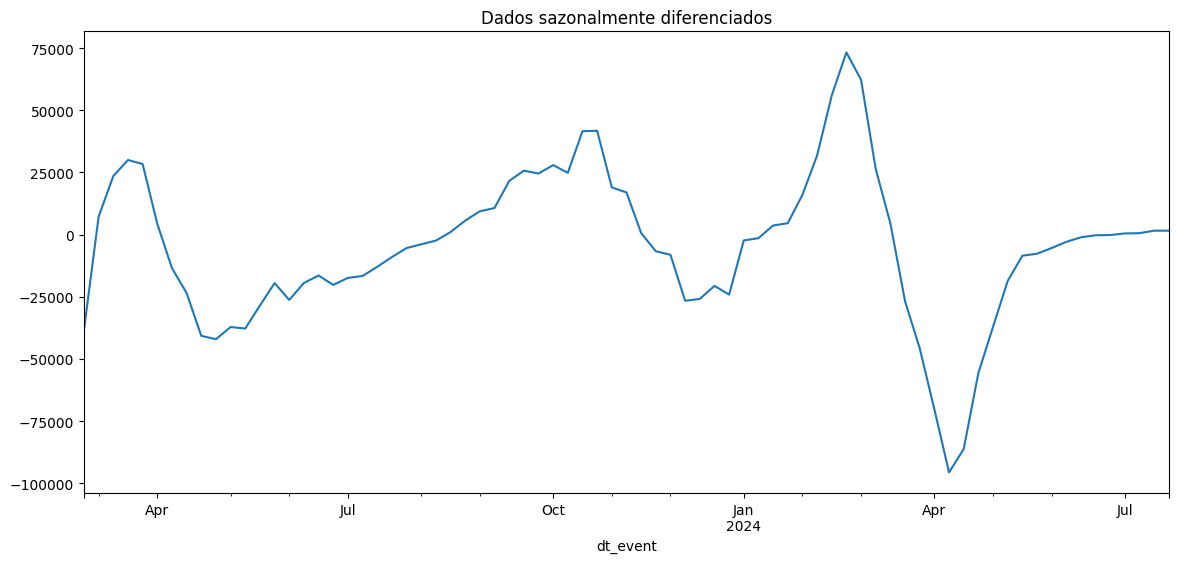

In [67]:
# parâmetros sazonais
# Diferença sazonal
fig = plt.figure(figsize=(14,6))

seasonal_diff = treino['count'].diff(7).dropna()

seasonal_diff.plot()
plt.title('Dados sazonalmente diferenciados')
plt.show()

In [68]:
results = adfuller(seasonal_diff)
output = pd.Series(results[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in results[4].items():
    output['Critical Value (%s)'%key] = value
print(output)

Test Statistic                 -3.567742
p-value                         0.006409
#Lags Used                      5.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64


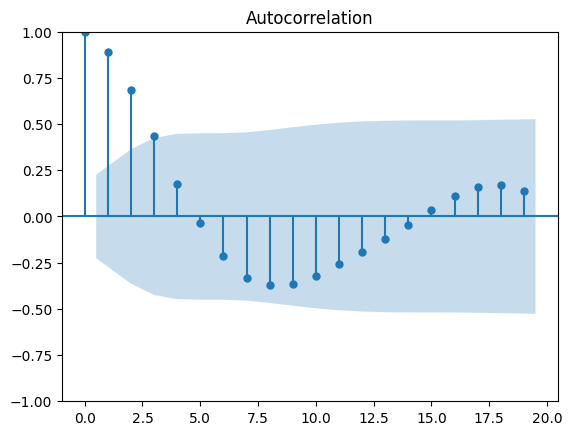

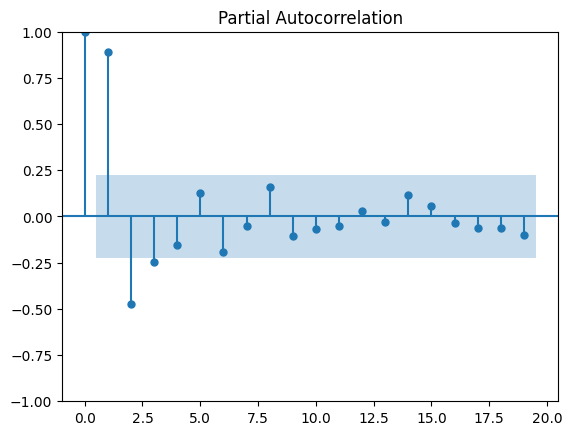

In [69]:
plot_acf(seasonal_diff)
plt.show()

plot_pacf(seasonal_diff)
plt.show()

In [31]:
# Converter a coluna de datas para o formato datetime e definir como índice
treino['dt_event'] = pd.to_datetime(treino['dt_event'])
treino.set_index('dt_event', inplace=True)

C:\Users\pedro.sa\AppData\Local\Temp\ipykernel_34252\354360687.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino['dt_event'] = pd.to_datetime(treino['dt_event'])


In [32]:
teste['dt_event'] = pd.to_datetime(teste['dt_event'])
teste.set_index('dt_event', inplace=True)

C:\Users\pedro.sa\AppData\Local\Temp\ipykernel_34252\823965547.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teste['dt_event'] = pd.to_datetime(teste['dt_event'])


### Modelo 1

In [33]:
# Criar e ajustar o modelo ARIMA
treino_model1 = ARIMA(treino['count'], order=(1, 1, 1))  # Configurar o modelo ARIMA com ordem (p,d,q)
treino_model_fit1 = treino_model1.fit()

# Exibir o resumo do modelo
print(treino_model_fit1.summary())

                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                   82
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -854.002
Date:                Fri, 03 Jan 2025   AIC                           1714.004
Time:                        16:06:34   BIC                           1721.188
Sample:                    01-07-2023   HQIC                          1716.886
                         - 07-27-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8940      0.031     29.043      0.000       0.834       0.954
ma.L1         -1.0000      0.107     -9.319      0.000      -1.210      -0.790
sigma2      8.256e+07    1.3e-09   6.35e+16      0.0

D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)


In [34]:
# Forecast
teste_forecast1 = treino_model_fit1.get_forecast(steps=len(teste))
teste_forecast_series1 = pd.Series(teste_forecast1.predicted_mean, index=teste.index)

In [35]:
# Calculando o erro quadrado médio
mse = mean_squared_error(teste['count'], teste_forecast_series1)
rmse = mse ** 0.5

print(mse)
print(rmse)

82280604.12814796
9070.865676888174


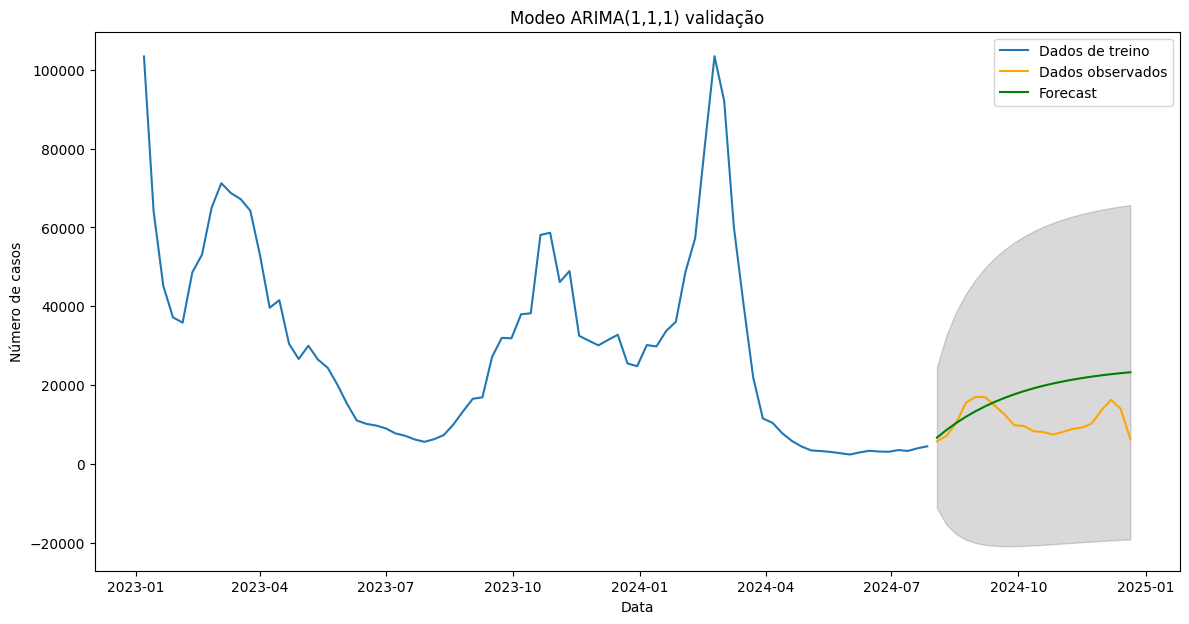

RMSE:  9070.865676888174


In [36]:
# Visualização dos dados
plt.figure(figsize=(14, 7))
plt.plot(treino['count'], label = 'Dados de treino')
plt.plot(teste['count'], label= 'Dados observados', color = 'orange')
plt.plot(teste_forecast_series1, label='Forecast', color='green')
plt.fill_between(teste.index,
                 teste_forecast1.conf_int().iloc[:, 0],
                 teste_forecast1.conf_int().iloc[:, 1],
                 color='k', alpha=0.15)
plt.title('Modeo ARIMA(1,1,1) validação')
plt.xlabel('Data')
plt.ylabel('Número de casos')
plt.legend()
plt.show()

print('RMSE: ', rmse)

### Modelo 2

In [63]:
# Criar e ajustar o modelo ARIMA
treino_model2 = ARIMA(treino['count'], order=(2, 1, 2))  # Configurar o modelo ARIMA com ordem (p,d,q)
treino_model_fit2 = treino_model2.fit()

# Exibir o resumo do modelo
print(treino_model_fit2.summary())

                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                   82
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -853.765
Date:                Fri, 03 Jan 2025   AIC                           1717.529
Time:                        16:22:18   BIC                           1729.502
Sample:                    01-07-2023   HQIC                          1722.333
                         - 07-27-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0881      0.339      0.260      0.795      -0.576       0.752
ar.L2          0.7113      0.310      2.292      0.022       0.103       1.319
ma.L1         -0.1625      0.371     -0.438      0.6

D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [64]:
# Forecast
teste_forecast2 = treino_model_fit2.get_forecast(steps=len(teste))
teste_forecast_series2 = pd.Series(teste_forecast2.predicted_mean, index=teste.index)

In [65]:
# Calculando o erro quadrado médio
mse = mean_squared_error(teste['count'], teste_forecast_series2)
rmse = mse ** 0.5

print(mse)
print(rmse)

86624740.15303294
9307.241275105795


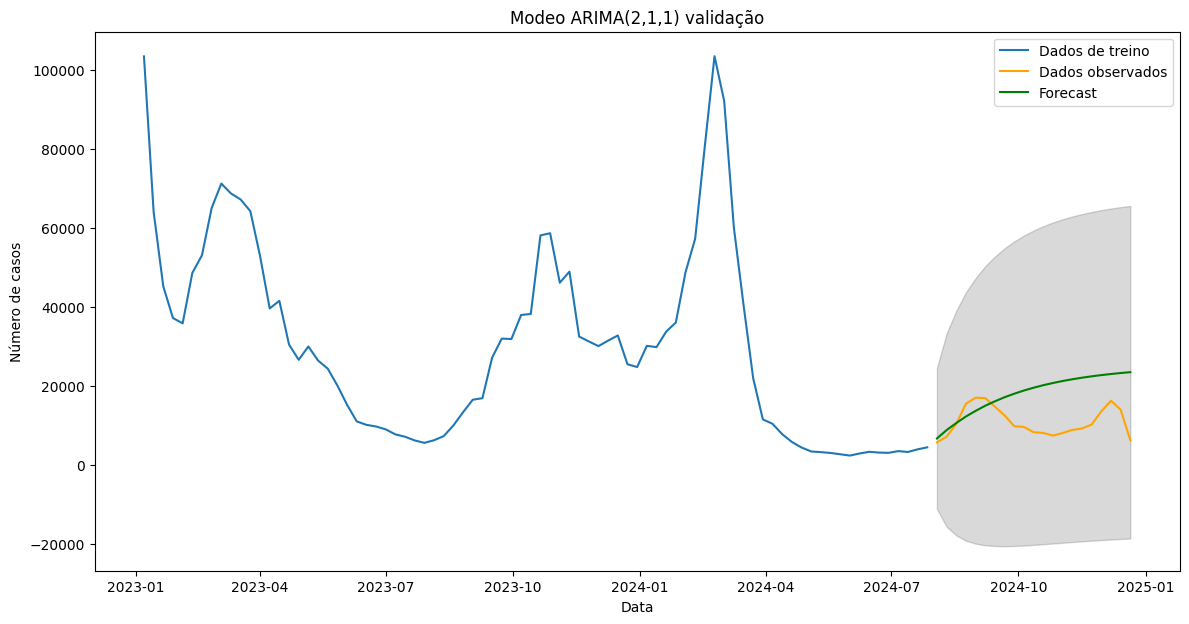

RMSE:  9307.241275105795


In [66]:
# Visualização dos dados
plt.figure(figsize=(14, 7))
plt.plot(treino['count'], label = 'Dados de treino')
plt.plot(teste['count'], label= 'Dados observados', color = 'orange')
plt.plot(teste_forecast_series2, label='Forecast', color='green')
plt.fill_between(teste.index,
                 teste_forecast2.conf_int().iloc[:, 0],
                 teste_forecast2.conf_int().iloc[:, 1],
                 color='k', alpha=0.15)
plt.title('Modeo ARIMA(2,1,1) validação')
plt.xlabel('Data')
plt.ylabel('Número de casos')
plt.legend()
plt.show()

print('RMSE: ', rmse)

### Modelo 3 - SARIMA

In [78]:
# Intervalos de parâmetros
p = range(0,2)
d = range(0,1)
q = range(0,2)
s = [7]

# Encontrar todos os parâmetros
pdq = list(product(p,d,q))
seasonal_pdq = list(product(p,d,q,s))

# Criar modelo SARIMA para cada ordem e cada ordem sazonal
aics = []
for order in pdq:
    for seasonal_order in seasonal_pdq:
        try:
            model = SARIMAX(treino['count'], order=order, seasonal_order=seasonal_order)
            results = model.fit()
            aics.append(order, seasonal_order, results.aic)
        except:
            print('SARIMA{}, {} - Skipped'.format(order, seasonal_order))

# Checar menor AIC
aics.sort(key=lambda x: x[2])
print(aics[0])

D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-

SARIMA(0, 0, 0), (0, 0, 0, 7) - Skipped
SARIMA(0, 0, 0), (0, 0, 1, 7) - Skipped
SARIMA(0, 0, 0), (1, 0, 0, 7) - Skipped
SARIMA(0, 0, 0), (1, 0, 1, 7) - Skipped
SARIMA(0, 0, 1), (0, 0, 0, 7) - Skipped
SARIMA(0, 0, 1), (0, 0, 1, 7) - Skipped
SARIMA(0, 0, 1), (1, 0, 0, 7) - Skipped
SARIMA(0, 0, 1), (1, 0, 1, 7) - Skipped
SARIMA(1, 0, 0), (0, 0, 0, 7) - Skipped
SARIMA(1, 0, 0), (0, 0, 1, 7) - Skipped
SARIMA(1, 0, 0), (1, 0, 0, 7) - Skipped
SARIMA(1, 0, 0), (1, 0, 1, 7) - Skipped
SARIMA(1, 0, 1), (0, 0, 0, 7) - Skipped


D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-

SARIMA(1, 0, 1), (0, 0, 1, 7) - Skipped
SARIMA(1, 0, 1), (1, 0, 0, 7) - Skipped
SARIMA(1, 0, 1), (1, 0, 1, 7) - Skipped


D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)


IndexError: list index out of range

In [120]:
# Criar e ajustar o modelo ARIMA
treino_model_sarima = SARIMAX(treino['count'], order=(4, 1, 4), seasonal_order=(2,1,2,7))  # Configurar o modelo ARIMA com ordem (p,d,q)
treino_model_sarima_fit = treino_model_sarima.fit()

# Exibir o resumo do modelo
print(treino_model_sarima_fit.summary())

D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)


                                       SARIMAX Results                                        
Dep. Variable:                                  count   No. Observations:                   82
Model:             SARIMAX(4, 1, 4)x(2, 1, [1, 2], 7)   Log Likelihood                -788.377
Date:                                Fri, 03 Jan 2025   AIC                           1602.755
Time:                                        17:33:12   BIC                           1632.708
Sample:                                    01-07-2023   HQIC                          1614.703
                                         - 07-27-2024                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2399      0.599      0.401      0.689      -0.934       1.413
ar.

D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [121]:
# Forecast
teste_forecast_sarima = treino_model_sarima_fit.get_forecast(steps=len(teste))
teste_forecast_series_sarima = pd.Series(teste_forecast_sarima.predicted_mean, index=teste.index)

In [122]:
# Calculando o erro quadrado médio
mse = mean_squared_error(teste['count'], teste_forecast_series_sarima)
rmse = mse ** 0.5

print(mse)
print(rmse)

12109605.248549735
3479.8858096997574


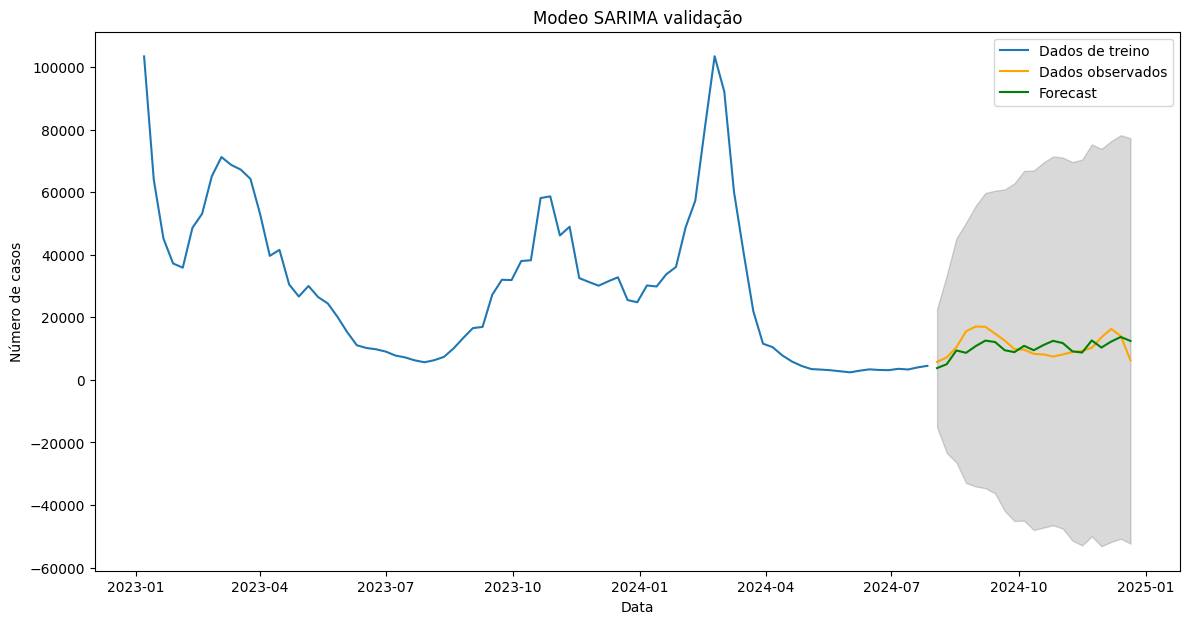

RMSE:  3479.8858096997574


In [123]:
# Visualização dos dados
plt.figure(figsize=(14, 7))
plt.plot(treino['count'], label = 'Dados de treino')
plt.plot(teste['count'], label= 'Dados observados', color = 'orange')
plt.plot(teste_forecast_series_sarima, label='Forecast', color='green')
plt.fill_between(teste.index,
                 teste_forecast_sarima.conf_int().iloc[:, 0],
                 teste_forecast_sarima.conf_int().iloc[:, 1],
                 color='k', alpha=0.15)
plt.title('Modeo SARIMA validação')
plt.xlabel('Data')
plt.ylabel('Número de casos')
plt.legend()
plt.show()

print('RMSE: ', rmse)